In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
datagambar = '/content/drive/MyDrive/Potato Diseases/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files = [i for i in glob.glob(datagambar + "//*//*")]
labels = [os.path.dirname(i).split("/")[-1] for i in files]
dataframe = pd.DataFrame(zip(files, labels), columns = ["Image", "Label"])

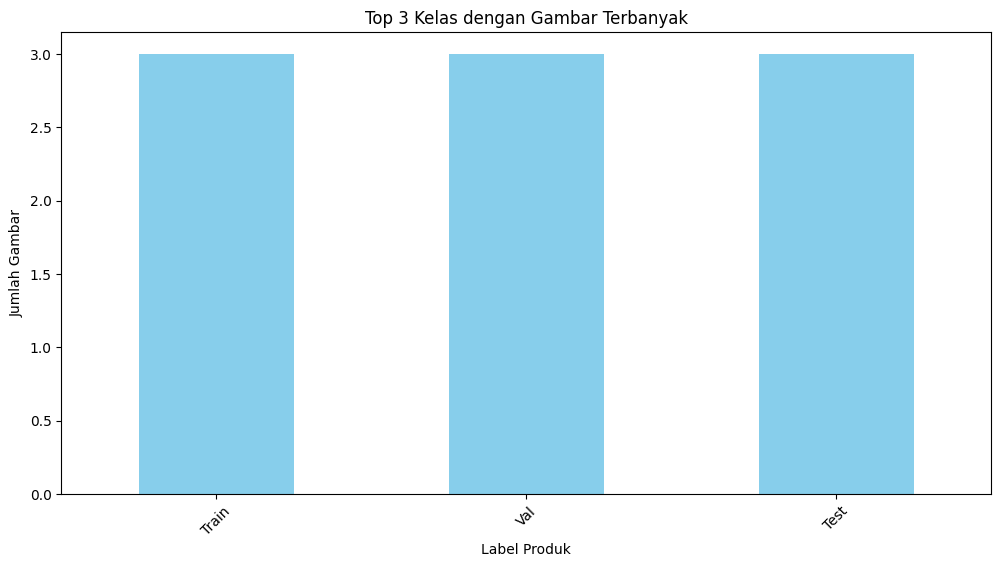

In [ ]:
# Menampilkan 3 kelas dengan jumlah gambar terbanyak
plt.figure(figsize=(12, 6))
dataframe['Label'].value_counts().head(3).plot(kind='bar', color='skyblue')
plt.title('Top 3 Kelas dengan Gambar Terbanyak')
plt.xlabel('Label Produk')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Menghitung statistik distribusi
print("Distribusi jumlah gambar per label:")
print(dataframe['Label'].value_counts().describe())

Distribusi jumlah gambar per label:
count    3.0
mean     3.0
std      0.0
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: count, dtype: float64


In [ ]:
# Menghitung statistik distribusi
print("Distribusi jumlah gambar per label:")
print(dataframe['Label'].value_counts().describe())
print("Distribusi data sangat condong ke kanan (higly positively skewed).")

Distribusi jumlah gambar per label:
count    3.0
mean     3.0
std      0.0
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: count, dtype: float64
Distribusi data sangat condong ke kanan (higly positively skewed).


In [ ]:
from sklearn.utils import class_weight
# Label dari dataframe akan digunakan untuk menghitung bobot
class_labels = dataframe['Label'].values
unique_labels = np.unique(class_labels)

In [ ]:
# Menghitung bobot kelas
# 'balanced' secara otomatis memberikan bobot yang berbanding terbalik dengan frekuensi kelas
class_weights = class_weight.compute_class_weight(
class_weight='balanced',
classes=unique_labels,
y=class_labels
)

In [ ]:
# Membuat dictionary untuk memetakan indeks kelas ke bobotnya
# Genarator data akan mengurutkan kelas secara alfabet
class_indices = {label: i for i, label in enumerate(np.sort(unique_labels))}
class_weights_dict = {class_indices[label]: weight for label, weight in
zip(unique_labels, class_weights)}

print("Bobot Kelas yang akan Digunakan:")
# print(class_weights_dict)
# Uncomment untuk melihat bobot detail
print(f"Total kelas: {len(class_weights_dict)}. Bobot telah dihitung dan siap digunakan.")

Bobot Kelas yang akan Digunakan:
Total kelas: 3. Bobot telah dihitung dan siap digunakan.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Konfigurasi ImageDataGenerator untuk augmentasi data latih
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
# Hanya lakukan rescale untuk data uji (tidak ada augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255) #
BATCH_SIZE = 64 #

In [ ]:
# Membuat generator data dari direktori
train_generator = train_datagen.flow_from_directory(
'/content/drive/MyDrive/Potato Diseases/Train/', #
  target_size=(128, 128), #
  batch_size=BATCH_SIZE, #
  class_mode='categorical' #
)

test_generator = test_datagen.flow_from_directory(
'/content/drive/MyDrive/Potato Diseases/Test/', #
  target_size=(128, 128), #
  batch_size=BATCH_SIZE, #
  class_mode='categorical' #
)

Found 1190 images belonging to 3 classes.
Found 302 images belonging to 3 classes.


In [ ]:
# Simpan nama-nama kelas ke file teks
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for item in labels:
    f.write("%s\n" % item)

# **Memuat Mobile net**

In [ ]:
# Memuat MobileNetV2 sebagai model dasar, tanpa lapisan atas, dan dengan bobot dari ImageNet
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Membekukan bobot model dasar
mobile_net.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout,BatchNormalization,InputLayer

model = Sequential([

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.30),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.35),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.40),


    # Dense Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(train_generator.num_classes, activation='softmax')
])

In [ ]:
# Kompilasi model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
# loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
# metrics=['accuracy'])
# model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,633,827 (36.75 MB)

 Trainable params: 9,630,627 (36.74 MB)

 Non-trainable params: 3,200 (12.50 KB)

# **Pelatihan Dan Evaluasi**

In [ ]:
# Tentukan jumlah epoch awal
initial_epochs = 90

# Latih model
history = model.fit(
  train_generator,
  epochs=initial_epochs,
  validation_data=test_generator,
  class_weight=class_weights_dict, #class_weighting
  verbose=1
)


# Menyimpan hasil history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(initial_epochs)

# Membuat plot
plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Tampilkan grafik
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

# Penyimpana model Yang sudah Dilatih

In [ ]:
# # 1. Simpan model ke format Keras
# model.save('my_model.keras')

# # 2. Konversi ke TensorFlow SavedModel
# keras_model = tf.keras.models.load_model('my_model.keras')
# tf.saved_model.save(keras_model, 'my_saved_model')

# # 3. Konversi ke TFLite FLOAT32 (standar)
# converter = tf.lite.TFLiteConverter.from_saved_model('my_saved_model')
# tflite_model = converter.convert()
# with open('model_float32.tflite', 'wb') as f:f.write(tflite_model)

# # 4. Konversi ke TFLite UINT8 (terkuantisasi)
# def representative_data_gen():
#   for input_value, _ in train_generator:
#     yield [input_value]
#     break # Cukup satu batch untuk data representatif

# converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops =
# [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8
# tflite_model_quant = converter.convert()
# with open('my_model_quantized_uint8.tflite', 'wb') as f:f.write(tflite_model_quant)
# print("Model berhasil disimpan dalam format .keras, SavedModel, dan TFLite(float32 & uint8).")